# Meta-Analysis in statsmodels

Statsmodels include basic methods for meta-analysis. This notebook illustrates the current usage.

Status: The results have been verified against R meta and metafor packages. However, the API is still experimental and will still change. Some options for additional methods that are available in R meta and metafor are missing.

The support for meta-analysis has 3 parts:

- effect size functions: this currently includes
  ``effectsize_smd`` computes effect size and their standard errors for standardized mean difference,  
  ``effectsize_2proportions`` computes effect sizes for comparing two independent proportions using risk difference, (log) risk ratio, (log) odds-ratio or arcsine square root transformation
- The `combine_effects` computes fixed and random effects estimate for the overall mean or effect. The returned results instance includes a forest plot function.
- helper functions to estimate the random effect variance, tau-squared

The estimate of the overall effect size in `combine_effects` can also be performed using WLS or GLM with var_weights.

Finally, the meta-analysis functions currently do not include the Mantel-Hanszel method. However, the fixed effects results can be computed directly using `StratifiedTable` as illustrated below.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, optimize

from statsmodels.regression.linear_model import WLS
from statsmodels.genmod.generalized_linear_model import GLM

from statsmodels.stats.meta_analysis import (
    effectsize_smd,
    effectsize_2proportions,
    combine_effects,
    _fit_tau_iterative,
    _fit_tau_mm,
    _fit_tau_iter_mm,
)

# increase line length for pandas
pd.set_option("display.width", 100)

## Example

In [3]:
data = [
    ["Carroll", 94, 22, 60, 92, 20, 60],
    ["Grant", 98, 21, 65, 92, 22, 65],
    ["Peck", 98, 28, 40, 88, 26, 40],
    ["Donat", 94, 19, 200, 82, 17, 200],
    ["Stewart", 98, 21, 50, 88, 22, 45],
    ["Young", 96, 21, 85, 92, 22, 85],
]
colnames = ["study", "mean_t", "sd_t", "n_t", "mean_c", "sd_c", "n_c"]
rownames = [i[0] for i in data]
dframe1 = pd.DataFrame(data, columns=colnames)
rownames

['Carroll', 'Grant', 'Peck', 'Donat', 'Stewart', 'Young']

In [4]:
mean2, sd2, nobs2, mean1, sd1, nobs1 = np.asarray(
    dframe1[["mean_t", "sd_t", "n_t", "mean_c", "sd_c", "n_c"]]
).T
rownames = dframe1["study"]
rownames.tolist()

['Carroll', 'Grant', 'Peck', 'Donat', 'Stewart', 'Young']

In [5]:
np.array(nobs1 + nobs2)

array([120, 130,  80, 400,  95, 170])

### estimate effect size standardized mean difference

In [6]:
eff, var_eff = effectsize_smd(mean2, sd2, nobs2, mean1, sd1, nobs1)

### Using one-step chi2, DerSimonian-Laird estimate for random effects variance tau

Method option for random effect `method_re="chi2"` or `method_re="dl"`, both names are accepted.
This is commonly referred to as the DerSimonian-Laird method, it is based on a moment estimator based on pearson chi2 from the fixed effects estimate.

In [7]:
res3 = combine_effects(eff, var_eff, method_re="chi2", use_t=True, row_names=rownames)
# TODO: we still need better information about conf_int of individual samples
# We don't have enough information in the model for individual confidence intervals
# if those are not based on normal distribution.
res3.conf_int_samples(nobs=np.array(nobs1 + nobs2))
print(res3.summary_frame())

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Carroll            0.094524  0.182680 -0.267199  0.456248  0.123885  0.157529
Grant              0.277356  0.176279 -0.071416  0.626129  0.133045  0.162828
Peck               0.366546  0.225573 -0.082446  0.815538  0.081250  0.126223
Donat              0.664385  0.102748  0.462389  0.866381  0.391606  0.232734
Stewart            0.461808  0.208310  0.048203  0.875413  0.095275  0.137949
Young              0.185165  0.153729 -0.118312  0.488641  0.174939  0.182736
fixed effect       0.414961  0.064298  0.249677  0.580245  1.000000       NaN
random effect      0.358486  0.105462  0.087388  0.629583       NaN  1.000000
fixed effect wls   0.414961  0.099237  0.159864  0.670058  1.000000       NaN
random effect wls  0.358486  0.090328  0.126290  0.590682       NaN  1.000000


In [8]:
res3.cache_ci

{(0.05,
  True): (array([-0.26719942, -0.07141628, -0.08244568,  0.46238908,  0.04820269,
         -0.1183121 ]), array([0.45624817, 0.62612908, 0.81553838, 0.86638112, 0.87541326,
         0.48864139]))}

In [9]:
res3.method_re

'chi2'

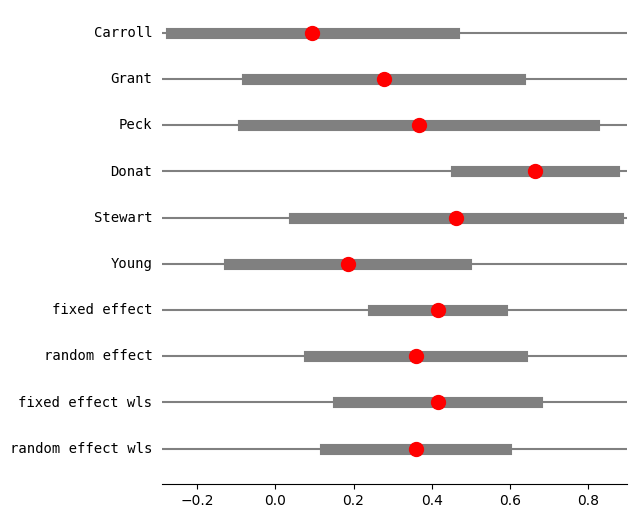

In [10]:
fig = res3.plot_forest()
fig.set_figheight(6)
fig.set_figwidth(6)

In [11]:
res3 = combine_effects(eff, var_eff, method_re="chi2", use_t=False, row_names=rownames)
# TODO: we still need better information about conf_int of individual samples
# We don't have enough information in the model for individual confidence intervals
# if those are not based on normal distribution.
res3.conf_int_samples(nobs=np.array(nobs1 + nobs2))
print(res3.summary_frame())

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Carroll            0.094524  0.182680 -0.263521  0.452570  0.123885  0.157529
Grant              0.277356  0.176279 -0.068144  0.622857  0.133045  0.162828
Peck               0.366546  0.225573 -0.075569  0.808662  0.081250  0.126223
Donat              0.664385  0.102748  0.463002  0.865768  0.391606  0.232734
Stewart            0.461808  0.208310  0.053527  0.870089  0.095275  0.137949
Young              0.185165  0.153729 -0.116139  0.486468  0.174939  0.182736
fixed effect       0.414961  0.064298  0.288939  0.540984  1.000000       NaN
random effect      0.358486  0.105462  0.151785  0.565187       NaN  1.000000
fixed effect wls   0.414961  0.099237  0.220460  0.609462  1.000000       NaN
random effect wls  0.358486  0.090328  0.181446  0.535526       NaN  1.000000


### Using iterated, Paule-Mandel estimate for random effects variance tau

The method commonly referred to as Paule-Mandel estimate is a method of moment estimate for the random effects variance that iterates between mean and variance estimate until convergence.


method RE: iterated
                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Carroll            0.094524  0.182680 -0.263521  0.452570  0.123885  0.152619
Grant              0.277356  0.176279 -0.068144  0.622857  0.133045  0.159157
Peck               0.366546  0.225573 -0.075569  0.808662  0.081250  0.116228
Donat              0.664385  0.102748  0.463002  0.865768  0.391606  0.257767
Stewart            0.461808  0.208310  0.053527  0.870089  0.095275  0.129428
Young              0.185165  0.153729 -0.116139  0.486468  0.174939  0.184799
fixed effect       0.414961  0.064298  0.288939  0.540984  1.000000       NaN
random effect      0.366419  0.092390  0.185338  0.547500       NaN  1.000000
fixed effect wls   0.414961  0.099237  0.220460  0.609462  1.000000       NaN
random effect wls  0.366419  0.092390  0.185338  0.547500       NaN  1.000000


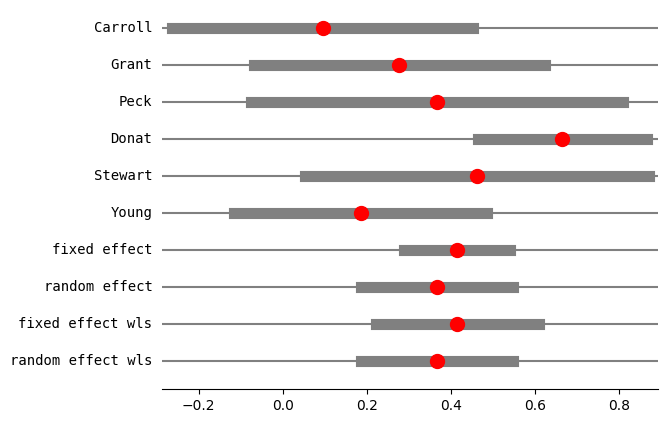

In [12]:
res4 = combine_effects(
    eff, var_eff, method_re="iterated", use_t=False, row_names=rownames
)
res4_df = res4.summary_frame()
print("method RE:", res4.method_re)
print(res4.summary_frame())
fig = res4.plot_forest()

## Example Kacker interlaboratory mean

In this example the effect size is the mean of measurements in a lab. We combine the estimates from several labs to estimate and overall average.

In [13]:
eff = np.array([61.00, 61.40, 62.21, 62.30, 62.34, 62.60, 62.70, 62.84, 65.90])
var_eff = np.array(
    [0.2025, 1.2100, 0.0900, 0.2025, 0.3844, 0.5625, 0.0676, 0.0225, 1.8225]
)
rownames = ["PTB", "NMi", "NIMC", "KRISS", "LGC", "NRC", "IRMM", "NIST", "LNE"]

method RE: dl
                         eff    sd_eff     ci_low     ci_upp      w_fe      w_re
PTB                61.000000  0.450000  60.118016  61.881984  0.057436  0.123113
NMi                61.400000  1.100000  59.244040  63.555960  0.009612  0.040314
NIMC               62.210000  0.300000  61.622011  62.797989  0.129230  0.159749
KRISS              62.300000  0.450000  61.418016  63.181984  0.057436  0.123113
LGC                62.340000  0.620000  61.124822  63.555178  0.030257  0.089810
NRC                62.600000  0.750000  61.130027  64.069973  0.020677  0.071005
IRMM               62.700000  0.260000  62.190409  63.209591  0.172052  0.169810
NIST               62.840000  0.150000  62.546005  63.133995  0.516920  0.194471
LNE                65.900000  1.350000  63.254049  68.545951  0.006382  0.028615
fixed effect       62.583397  0.107846  62.334704  62.832090  1.000000       NaN
random effect      62.390139  0.245750  61.823439  62.956838       NaN  1.000000
fixed effect w

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/statsmodels/stats/meta_analysis.py:105: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


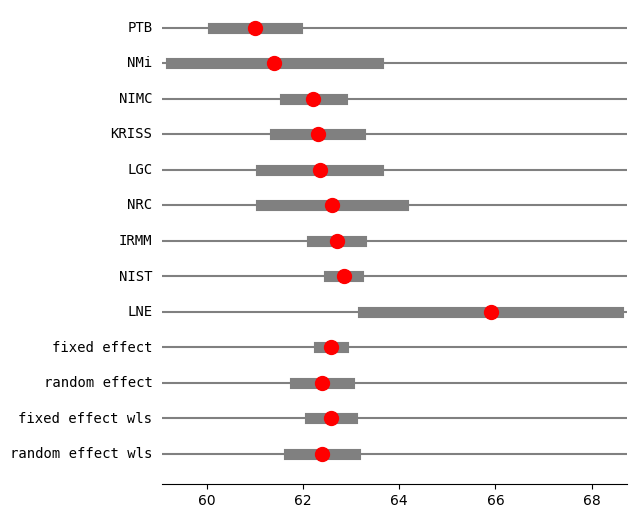

In [14]:
res2_DL = combine_effects(eff, var_eff, method_re="dl", use_t=True, row_names=rownames)
print("method RE:", res2_DL.method_re)
print(res2_DL.summary_frame())
fig = res2_DL.plot_forest()
fig.set_figheight(6)
fig.set_figwidth(6)

method RE: pm
                         eff    sd_eff     ci_low     ci_upp      w_fe      w_re
PTB                61.000000  0.450000  60.118016  61.881984  0.057436  0.125857
NMi                61.400000  1.100000  59.244040  63.555960  0.009612  0.059656
NIMC               62.210000  0.300000  61.622011  62.797989  0.129230  0.143658
KRISS              62.300000  0.450000  61.418016  63.181984  0.057436  0.125857
LGC                62.340000  0.620000  61.124822  63.555178  0.030257  0.104850
NRC                62.600000  0.750000  61.130027  64.069973  0.020677  0.090122
IRMM               62.700000  0.260000  62.190409  63.209591  0.172052  0.147821
NIST               62.840000  0.150000  62.546005  63.133995  0.516920  0.156980
LNE                65.900000  1.350000  63.254049  68.545951  0.006382  0.045201
fixed effect       62.583397  0.107846  62.334704  62.832090  1.000000       NaN
random effect      62.407620  0.338030  61.628120  63.187119       NaN  1.000000
fixed effect w

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/statsmodels/stats/meta_analysis.py:105: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


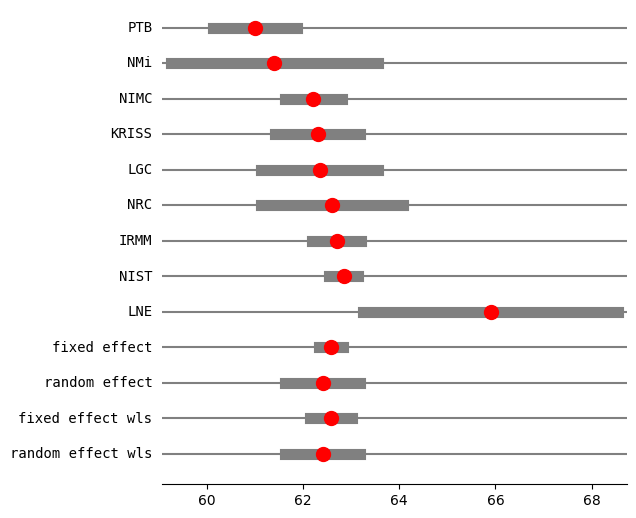

In [15]:
res2_PM = combine_effects(eff, var_eff, method_re="pm", use_t=True, row_names=rownames)
print("method RE:", res2_PM.method_re)
print(res2_PM.summary_frame())
fig = res2_PM.plot_forest()
fig.set_figheight(6)
fig.set_figwidth(6)

## Meta-analysis of proportions

In the following example the random effect variance tau is estimated to be zero. 
I then change two counts in the data, so the second example has random effects variance greater than zero.

In [16]:
import io

In [17]:
ss = """\
    study,nei,nci,e1i,c1i,e2i,c2i,e3i,c3i,e4i,c4i
    1,19,22,16.0,20.0,11,12,4.0,8.0,4,3
    2,34,35,22.0,22.0,18,12,15.0,8.0,15,6
    3,72,68,44.0,40.0,21,15,10.0,3.0,3,0
    4,22,20,19.0,12.0,14,5,5.0,4.0,2,3
    5,70,32,62.0,27.0,42,13,26.0,6.0,15,5
    6,183,94,130.0,65.0,80,33,47.0,14.0,30,11
    7,26,50,24.0,30.0,13,18,5.0,10.0,3,9
    8,61,55,51.0,44.0,37,30,19.0,19.0,11,15
    9,36,25,30.0,17.0,23,12,13.0,4.0,10,4
    10,45,35,43.0,35.0,19,14,8.0,4.0,6,0
    11,246,208,169.0,139.0,106,76,67.0,42.0,51,35
    12,386,141,279.0,97.0,170,46,97.0,21.0,73,8
    13,59,32,56.0,30.0,34,17,21.0,9.0,20,7
    14,45,15,42.0,10.0,18,3,9.0,1.0,9,1
    15,14,18,14.0,18.0,13,14,12.0,13.0,9,12
    16,26,19,21.0,15.0,12,10,6.0,4.0,5,1
    17,74,75,,,42,40,,,23,30"""
df3 = pd.read_csv(io.StringIO(ss))
df_12y = df3[["e2i", "nei", "c2i", "nci"]]
# TODO: currently 1 is reference, switch labels
count1, nobs1, count2, nobs2 = df_12y.values.T
dta = df_12y.values.T

In [18]:
eff, var_eff = effectsize_2proportions(*dta, statistic="rd")

In [19]:
eff, var_eff

(array([ 0.03349282,  0.18655462,  0.07107843,  0.38636364,  0.19375   ,
         0.08609464,  0.14      ,  0.06110283,  0.15888889,  0.02222222,
         0.06550969,  0.11417337,  0.04502119,  0.2       ,  0.15079365,
        -0.06477733,  0.03423423]),
 array([0.02409958, 0.01376482, 0.00539777, 0.01989341, 0.01096641,
        0.00376814, 0.01422338, 0.00842011, 0.01639261, 0.01227827,
        0.00211165, 0.00219739, 0.01192067, 0.016     , 0.0143398 ,
        0.02267994, 0.0066352 ]))

method RE: iterated
RE variance tau2: 0
                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.033493  0.155240 -0.270773  0.337758  0.017454  0.017454
1                  0.186555  0.117324 -0.043395  0.416505  0.030559  0.030559
2                  0.071078  0.073470 -0.072919  0.215076  0.077928  0.077928
3                  0.386364  0.141044  0.109922  0.662805  0.021145  0.021145
4                  0.193750  0.104721 -0.011499  0.398999  0.038357  0.038357
5                  0.086095  0.061385 -0.034218  0.206407  0.111630  0.111630
6                  0.140000  0.119262 -0.093749  0.373749  0.029574  0.029574
7                  0.061103  0.091761 -0.118746  0.240951  0.049956  0.049956
8                  0.158889  0.128034 -0.092052  0.409830  0.025660  0.025660
9                  0.022222  0.110807 -0.194956  0.239401  0.034259  0.034259
10                 0.065510  0.045953 -0.024556  0.155575  0.199199  0.199199
11                 0.114

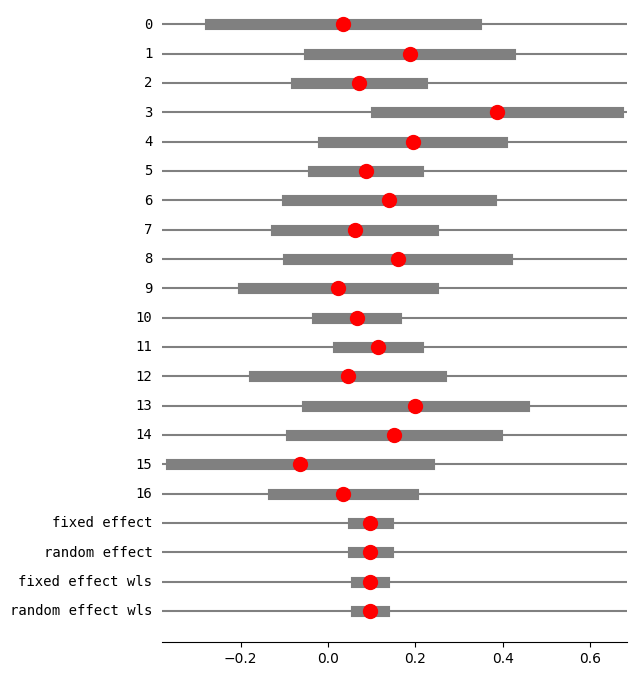

In [20]:
res5 = combine_effects(
    eff, var_eff, method_re="iterated", use_t=False
)  # , row_names=rownames)
res5_df = res5.summary_frame()
print("method RE:", res5.method_re)
print("RE variance tau2:", res5.tau2)
print(res5.summary_frame())
fig = res5.plot_forest()
fig.set_figheight(8)
fig.set_figwidth(6)

### changing data to have positive random effects variance

In [21]:
dta_c = dta.copy()
dta_c.T[0, 0] = 18
dta_c.T[1, 0] = 22
dta_c.T

array([[ 18,  19,  12,  22],
       [ 22,  34,  12,  35],
       [ 21,  72,  15,  68],
       [ 14,  22,   5,  20],
       [ 42,  70,  13,  32],
       [ 80, 183,  33,  94],
       [ 13,  26,  18,  50],
       [ 37,  61,  30,  55],
       [ 23,  36,  12,  25],
       [ 19,  45,  14,  35],
       [106, 246,  76, 208],
       [170, 386,  46, 141],
       [ 34,  59,  17,  32],
       [ 18,  45,   3,  15],
       [ 13,  14,  14,  18],
       [ 12,  26,  10,  19],
       [ 42,  74,  40,  75]])

method RE: iterated
                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.401914  0.117873  0.170887  0.632940  0.029850  0.038415
1                  0.304202  0.114692  0.079410  0.528993  0.031529  0.040258
2                  0.071078  0.073470 -0.072919  0.215076  0.076834  0.081017
3                  0.386364  0.141044  0.109922  0.662805  0.020848  0.028013
4                  0.193750  0.104721 -0.011499  0.398999  0.037818  0.046915
5                  0.086095  0.061385 -0.034218  0.206407  0.110063  0.102907
6                  0.140000  0.119262 -0.093749  0.373749  0.029159  0.037647
7                  0.061103  0.091761 -0.118746  0.240951  0.049255  0.058097
8                  0.158889  0.128034 -0.092052  0.409830  0.025300  0.033270
9                  0.022222  0.110807 -0.194956  0.239401  0.033778  0.042683
10                 0.065510  0.045953 -0.024556  0.155575  0.196403  0.141871
11                 0.114173  0.046876  0.022

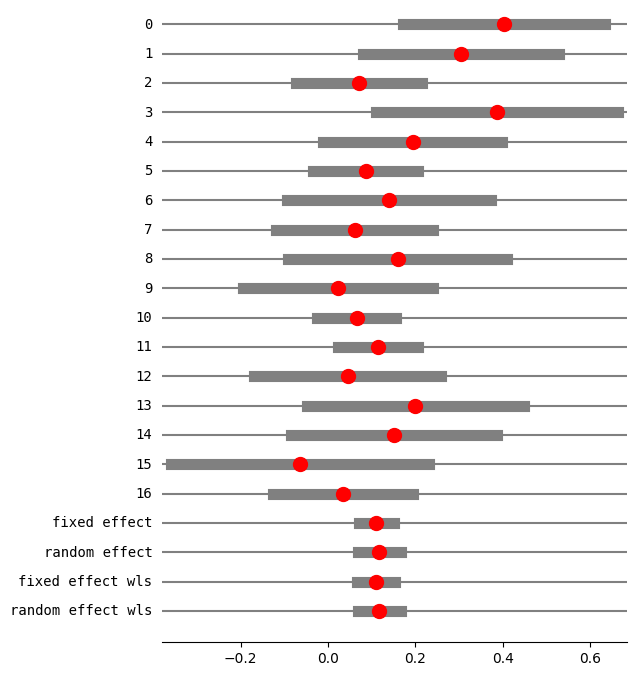

In [22]:
eff, var_eff = effectsize_2proportions(*dta_c, statistic="rd")
res5 = combine_effects(
    eff, var_eff, method_re="iterated", use_t=False
)  # , row_names=rownames)
res5_df = res5.summary_frame()
print("method RE:", res5.method_re)
print(res5.summary_frame())
fig = res5.plot_forest()
fig.set_figheight(8)
fig.set_figwidth(6)

method RE: chi2
                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.401914  0.117873  0.170887  0.632940  0.029850  0.036114
1                  0.304202  0.114692  0.079410  0.528993  0.031529  0.037940
2                  0.071078  0.073470 -0.072919  0.215076  0.076834  0.080779
3                  0.386364  0.141044  0.109922  0.662805  0.020848  0.025973
4                  0.193750  0.104721 -0.011499  0.398999  0.037818  0.044614
5                  0.086095  0.061385 -0.034218  0.206407  0.110063  0.105901
6                  0.140000  0.119262 -0.093749  0.373749  0.029159  0.035356
7                  0.061103  0.091761 -0.118746  0.240951  0.049255  0.056098
8                  0.158889  0.128034 -0.092052  0.409830  0.025300  0.031063
9                  0.022222  0.110807 -0.194956  0.239401  0.033778  0.040357
10                 0.065510  0.045953 -0.024556  0.155575  0.196403  0.154854
11                 0.114173  0.046876  0.022297 

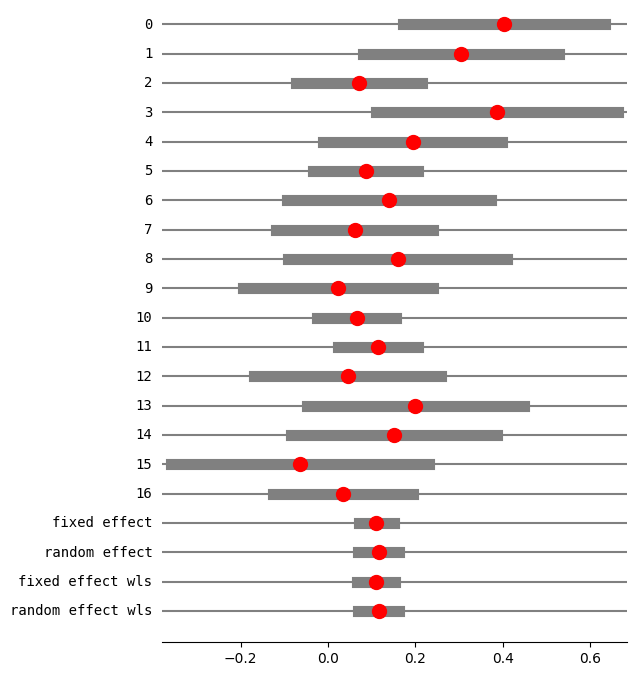

In [23]:
res5 = combine_effects(eff, var_eff, method_re="chi2", use_t=False)
res5_df = res5.summary_frame()
print("method RE:", res5.method_re)
print(res5.summary_frame())
fig = res5.plot_forest()
fig.set_figheight(8)
fig.set_figwidth(6)

### Replicate fixed effect analysis using GLM with var_weights

`combine_effects` computes weighted average estimates which can be replicated using GLM with var_weights or with WLS.
The `scale` option in `GLM.fit` can be used to replicate fixed meta-analysis with fixed and with HKSJ/WLS scale

In [24]:
from statsmodels.genmod.generalized_linear_model import GLM

In [25]:
eff, var_eff = effectsize_2proportions(*dta_c, statistic="or")
res = combine_effects(eff, var_eff, method_re="chi2", use_t=False)
res_frame = res.summary_frame()
print(res_frame.iloc[-4:])

                        eff    sd_eff    ci_low    ci_upp  w_fe  w_re
fixed effect       0.428037  0.090287  0.251076  0.604997   1.0   NaN
random effect      0.429520  0.091377  0.250425  0.608615   NaN   1.0
fixed effect wls   0.428037  0.090798  0.250076  0.605997   1.0   NaN
random effect wls  0.429520  0.091595  0.249997  0.609044   NaN   1.0


We need to fix scale=1 in order to replicate standard errors for the usual meta-analysis.

In [26]:
weights = 1 / var_eff
mod_glm = GLM(eff, np.ones(len(eff)), var_weights=weights)
res_glm = mod_glm.fit(scale=1.0)
print(res_glm.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4280      0.090      4.741      0.000       0.251       0.605


In [27]:
# check results
res_glm.scale, res_glm.conf_int() - res_frame.loc[
    "fixed effect", ["ci_low", "ci_upp"]
].values

(array(1.), array([[-5.55111512e-17,  0.00000000e+00]]))

Using HKSJ variance adjustment in meta-analysis is equivalent to estimating the scale using pearson chi2, which is also the default for the gaussian family.

In [28]:
res_glm = mod_glm.fit(scale="x2")
print(res_glm.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4280      0.091      4.714      0.000       0.250       0.606


In [29]:
# check results
res_glm.scale, res_glm.conf_int() - res_frame.loc[
    "fixed effect", ["ci_low", "ci_upp"]
].values

(1.0113358914264383, array([[-0.00100017,  0.00100017]]))

### Mantel-Hanszel odds-ratio using contingency tables

The fixed effect for the log-odds-ratio using the Mantel-Hanszel can be directly computed using StratifiedTable.

We need to create a 2 x 2 x k contingency table to be used with `StratifiedTable`.

In [30]:
t, nt, c, nc = dta_c
counts = np.column_stack([t, nt - t, c, nc - c])
ctables = counts.T.reshape(2, 2, -1)
ctables[:, :, 0]

array([[18,  1],
       [12, 10]])

In [31]:
counts[0]

array([18,  1, 12, 10])

In [32]:
dta_c.T[0]

array([18, 19, 12, 22])

In [33]:
import statsmodels.stats.api as smstats

In [34]:
st = smstats.StratifiedTable(ctables.astype(np.float64))

compare pooled log-odds-ratio and standard error to R meta package

In [35]:
st.logodds_pooled, st.logodds_pooled - 0.4428186730553189  # R meta

(0.4428186730553187, -2.220446049250313e-16)

In [36]:
st.logodds_pooled_se, st.logodds_pooled_se - 0.08928560091027186  # R meta

(0.08928560091027186, 0.0)

In [37]:
st.logodds_pooled_confint()

(0.2678221109331691, 0.6178152351774683)

In [38]:
print(st.test_equal_odds())

pvalue      0.34496419319878724
statistic   17.64707987033203


In [39]:
print(st.test_null_odds())

pvalue      6.615053645964153e-07
statistic   24.724136624311814


check conversion to stratified contingency table

Row sums of each table are the sample sizes for treatment and control experiments

In [40]:
ctables.sum(1)

array([[ 19,  34,  72,  22,  70, 183,  26,  61,  36,  45, 246, 386,  59,
         45,  14,  26,  74],
       [ 22,  35,  68,  20,  32,  94,  50,  55,  25,  35, 208, 141,  32,
         15,  18,  19,  75]])

In [41]:
nt, nc

(array([ 19,  34,  72,  22,  70, 183,  26,  61,  36,  45, 246, 386,  59,
         45,  14,  26,  74]),
 array([ 22,  35,  68,  20,  32,  94,  50,  55,  25,  35, 208, 141,  32,
         15,  18,  19,  75]))

**Results from R meta package**

```
> res_mb_hk = metabin(e2i, nei, c2i, nci, data=dat2, sm="OR", Q.Cochrane=FALSE, method="MH", method.tau="DL", hakn=FALSE, backtransf=FALSE)
> res_mb_hk
     logOR            95%-CI %W(fixed) %W(random)
1   2.7081 [ 0.5265; 4.8896]       0.3        0.7
2   1.2567 [ 0.2658; 2.2476]       2.1        3.2
3   0.3749 [-0.3911; 1.1410]       5.4        5.4
4   1.6582 [ 0.3245; 2.9920]       0.9        1.8
5   0.7850 [-0.0673; 1.6372]       3.5        4.4
6   0.3617 [-0.1528; 0.8762]      12.1       11.8
7   0.5754 [-0.3861; 1.5368]       3.0        3.4
8   0.2505 [-0.4881; 0.9892]       6.1        5.8
9   0.6506 [-0.3877; 1.6889]       2.5        3.0
10  0.0918 [-0.8067; 0.9903]       4.5        3.9
11  0.2739 [-0.1047; 0.6525]      23.1       21.4
12  0.4858 [ 0.0804; 0.8911]      18.6       18.8
13  0.1823 [-0.6830; 1.0476]       4.6        4.2
14  0.9808 [-0.4178; 2.3795]       1.3        1.6
15  1.3122 [-1.0055; 3.6299]       0.4        0.6
16 -0.2595 [-1.4450; 0.9260]       3.1        2.3
17  0.1384 [-0.5076; 0.7844]       8.5        7.6

Number of studies combined: k = 17

                      logOR           95%-CI    z  p-value
Fixed effect model   0.4428 [0.2678; 0.6178] 4.96 < 0.0001
Random effects model 0.4295 [0.2504; 0.6086] 4.70 < 0.0001

Quantifying heterogeneity:
 tau^2 = 0.0017 [0.0000; 0.4589]; tau = 0.0410 [0.0000; 0.6774];
 I^2 = 1.1% [0.0%; 51.6%]; H = 1.01 [1.00; 1.44]

Test of heterogeneity:
     Q d.f. p-value
 16.18   16  0.4404

Details on meta-analytical method:
- Mantel-Haenszel method
- DerSimonian-Laird estimator for tau^2
- Jackson method for confidence interval of tau^2 and tau

> res_mb_hk$TE.fixed
[1] 0.4428186730553189
> res_mb_hk$seTE.fixed
[1] 0.08928560091027186
> c(res_mb_hk$lower.fixed, res_mb_hk$upper.fixed)
[1] 0.2678221109331694 0.6178152351774684
 
```


In [42]:
print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.557   1.307 1.855
Pooled log odds       0.443   0.268 0.618
Pooled risk ratio     1.270              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1        24.724   0.000 
Test constant OR    17.647   0.345 
                       
-----------------------
Number of tables   17  
Min n              32  
Max n             527  
Avg n             139  
Total n          2362  
-----------------------
